In [1]:
import json
import spacy
import re

from tqdm import tqdm_notebook
import pandas as pd 

from collections import Counter

import matplotlib.pyplot as plt

from numpy.random import rand

from random import sample

In [2]:
import seaborn as sns

In [3]:
nlp = spacy.load('en')

In [4]:
f = open('./wrond_id_BERT_squad2.0_wa.txt','rt')
wrong_bert_wa = f.readlines()
f.close()

f = open('./wrond_id_BERT_squad2.0_fp.txt','rt')
wrong_bert_fp = f.readlines()
f.close()

f = open('./wrond_id_BERT_squad2.0_fn.txt','rt')
wrong_bert_fn = f.readlines()
f.close()

In [5]:
def removen(file):
    return [line.rstrip('\n') for line in file]

In [6]:
wrong_bert_wa = removen(wrong_bert_wa)
wrong_bert_fp = removen(wrong_bert_fp)
wrong_bert_fn = removen(wrong_bert_fn)

In [7]:
wrong_bert_wa = set(wrong_bert_wa)
wrong_bert_fp = set(wrong_bert_fp)
wrong_bert_fn = set(wrong_bert_fn)

In [8]:
f = open('./squad/dev-v2.0.json','rb')
data = json.load(f)

In [9]:
data = data['data']

In [10]:
all_qid = []

In [56]:
for document in data:
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            all_qid.append(qas['id'])

A function problem is a computational problem where a single output (of a total function) is expected for every input, but the output is more complex than that of a decision problem, that is, it isn't just yes or no. Notable examples include the traveling salesman problem and the integer factorization problem.
{'plausible_answers': [{'text': 'complex', 'answer_start': 142}], 'question': 'Is the output of a functional solution typically characterized by a simple or complex answer?', 'id': '5ad53e615b96ef001a10abde', 'answers': [], 'is_impossible': True}


In [66]:
fn_none = set(fn_none)

In [67]:
for document in data:
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            if qas['id'] in fn_none:
                print(paragraph['context'])
                print(qas)
                print("\n")

Many major classes of organic molecules in living organisms, such as proteins, nucleic acids, carbohydrates, and fats, contain oxygen, as do the major inorganic compounds that are constituents of animal shells, teeth, and bone. Most of the mass of living organisms is oxygen as it is a part of water, the major constituent of lifeforms. Oxygen is used in cellular respiration and released by photosynthesis, which uses the energy of sunlight to produce oxygen from water. It is too chemically reactive to remain a free element in air without being continuously replenished by the photosynthetic action of living organisms. Another form (allotrope) of oxygen, ozone (O
3), strongly absorbs UVB radiation and consequently the high-altitude ozone layer helps protect the biosphere from ultraviolet radiation, but is a pollutant near the surface where it is a by-product of smog. At even higher low earth orbit altitudes, sufficient atomic oxygen is present to cause erosion for spacecraft.
{'question': 

In [12]:
len(all_qid)

11873

In [13]:
right_qid = set(all_qid)-set(wrong_bert_wa)-set(wrong_bert_fp)-set(wrong_bert_fn)

In [14]:
f = open('sqaud2.0_bert_right.txt','w')
for qid in right_qid:
    f.write(qid+'\n')

In [15]:
len(all_qid)

11873

In [16]:
len(right_qid)

9553

In [17]:
def clearquestion(question):
    '''
    Clear the query if it contain unnecessary multiple quotes marks
    e.g) "What is the Milky Way?" --> What is the Milky Way?
    @param question
         	query string

    @return the cleaned setence
    '''
    
    if (question.startswith("\"") and question.endswith("\"")) or (question.startswith("\'") and question.endswith("\'")):
        question = question[1:-1]
        question = changepartsent("\"\"", "\"", question)
    
    return question

In [18]:
def changepartsent(word, reword, sentence):
    '''
    Change the part of sentence from word to reword
    @param word
         	@word that targeted to change
    @param reword
         	@word in sentence is replaced to @reword
    @param sentence
         	sentence string
    @return the changed string
    '''
    
    if type(word) is list:
        for w in word:
            sentence = sentence.replace(w,reword)

    else:
        sentence = sentence.replace(word,reword)
        sentence = sentence.replace(word[0].upper()+word[1:],reword)
    
    return sentence

In [19]:
candidate = ['when', 'how', 'where', 'which', 'what', 'who', 'how many', 'whose', 'whom', 'why']
how_words = ['many','tall','much','tall','old', 'often', 'deep', 'high', 'long', 'far', 'wide']
changelist = ['(what?)', '(what)', '(which?)', '(Which?)', '(which)', '(Which)']

## WH type wrong probability

In [20]:
def _wh_helper(sentence):
    doc = nlp(sentence)
    
    if sentence.startswith('name'): 
        return 'what'
        #return 'name'
    
    if 'how' in sentence.split():
        list_of_words = sentence.split()
        if list_of_words.index('how') != len(list_of_words)-1: 
            next_word = list_of_words[list_of_words.index('how') + 1]
            if next_word in how_words:
                return 'how many'
        
    
    for w in reversed(doc):
        if w.pos_ == 'NN': continue
        else:
            for can in candidate:
                if can in w.text.split():
                    return can
            break
    
    whs = []

    for idx, token in enumerate(doc):
        for can in candidate:
            if can in token.text.split():
                return can
            
    if doc[-1].lemma_ == 'be' or doc[-1].pos_ == 'ADP':
        return 'none'
        #return 'implicit_what'
    
    if 'name' in sentence.lower():
        return 'what'
        #return 'name'
    
    return 'none'

In [21]:
def findWHword(sentence):
    
    sentence = sentence.lower()
    osentence = sentence
    
    x = re.findall("\(wha.*?\)", sentence)

    if x != []:
        return 'cloze'
    
    if sentence.count('\"') > 0:
        sentence = changepartsent(re.findall(r'"([^"]*)"', sentence), 'QUOTES', sentence)
    if (sentence.count('\'')-sentence.count('\'s')) % 2 == 0 and sentence.count('\'')-sentence.count('\'s') > 0:
        sentence = changepartsent(re.findall(r"'(.*?)'", sentence), 'QUOTES', sentence)
        
    sentence = re.sub('\,.+?\,', '', sentence)
        
    wh = _wh_helper(sentence)
    if wh == 'none':
        wh = _wh_helper(osentence)
    
    return wh

In [22]:
whtype_dict = dict()

for can in candidate:
    whtype_dict[can] = []
whtype_dict['none'] = []
whtype_dict['implicit_what'] = []
whtype_dict['name'] = []
whtype_dict['cloze'] = []

qid_list = []
whtype_list = []
wrong_type_list = []
bert_solvable = []

for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            question = clearquestion(qas['question'])
            whtype = findWHword(question)
            if whtype == 'whose' or whtype == 'whom': whtype = 'who'

            whtype_dict[whtype].append(qas['id'])

            qid_list.append(qas['id'])
            whtype_list.append(whtype)
            
            count = 0
            if qas['id'] in wrong_bert_wa: wrong_type_list.append('wa')
            elif qas['id'] in wrong_bert_fp: wrong_type_list.append('fp')
            elif qas['id'] in wrong_bert_fn: wrong_type_list.append('fn')
            else: wrong_type_list.append('-')
                
            solvable = True if qas['id'] in right_qid else False
            
            bert_solvable.append(solvable)

In [23]:
for wh in whtype_dict:
    print("'{}': {}, ".format(wh, len(whtype_dict[wh])))

'when': 758, 
'how': 366, 
'where': 482, 
'which': 511, 
'what': 7430, 
'who': 1119, 
'how many': 903, 
'whose': 0, 
'whom': 0, 
'why': 194, 
'none': 97, 
'implicit_what': 2, 
'name': 11, 
'cloze': 0, 


In [23]:
del whtype_dict['whose'], whtype_dict['whom']
del whtype_dict['implicit_what'], whtype_dict['name'], whtype_dict['cloze']

In [24]:
# dictionary of lists
qid_dict = {'qid': qid_list, 'whtype': whtype_list, 'bert_solvable': bert_solvable, 'wrong_type': wrong_type_list}

In [50]:
df = pd.DataFrame(qid_dict)

In [31]:
df_all = df.copy(deep=True)

In [34]:
df_wa = df.loc[(df['wrong_type'] == 'wa')]

In [51]:
df_fp = df.loc[(df['wrong_type'] == 'fp')]

In [52]:
df_fn = df.loc[(df['wrong_type'] == 'fn')]

In [64]:
fn_none = df_fn.loc[df_fn['whtype'] == 'none'].qid

In [33]:
df.keys()

Index(['qid', 'whtype', 'RC_solvable', 'RC_solvable2', 'RC_solvable_count'], dtype='object')

In [33]:
WHtypes = ['None','how','how many','what','when','where','which','who','why']

In [34]:
WHtypes += ["ColTotal"]

In [35]:
# Table of survival vs passenger class
solvable_table = pd.crosstab(index=df["whtype"], 
                            columns=df["xlnet_solvable"], margins=True)


solvable_table.columns = ['unsolvable', 'solvable',"RowTotal"]
#solvable_table.index= WHtypes

solvable_table

,unsolvable,solvable,RowTotal
whtype,,,
None,19,51,70
how,107,331,438
how many,56,740,796
what,796,5241,6037
when,30,685,715
where,80,396,476
which,77,621,698
who,94,1091,1185
why,53,102,155


In [28]:
# Table of survival vs passenger class
solvable_table = pd.crosstab(index=df["whtype"], 
                            columns=df["wrong_type"], margins=True)


solvable_table.columns = ['Right','FN wrong','FP wrong','Wrong Answer',"RowTotal"]
#solvable_table.index= WHtypes

solvable_table

,Right,FN wrong,FP wrong,Wrong Answer,RowTotal
whtype,,,,,
how,244,20,39,63,366
how many,752,41,70,40,903
none,52,12,20,15,99
what,5992,335,579,535,7441
when,658,25,54,21,758
where,366,19,48,49,482
which,413,29,28,41,511
who,941,48,85,45,1119
why,135,15,13,31,194


In [71]:
solvable_table['RowTotal']

whtype
how                366
how many           903
implicit_what        2
name                11
none                97
what              7430
when               758
where              482
which              511
who               1119
why                194
All              11873
Name: RowTotal, dtype: int64

In [29]:
import seaborn as sns
solvable_table_m = solvable_table.copy(deep=True)
#solvable_table_m = solvable_table_m.drop('All')

In [29]:
solvable_table_m

,Right,FN wrong,FP wrong,Wrong Answer,RowTotal
whtype,,,,,
how,244,20,39,63,366
how many,752,41,70,40,903
implicit_what,0,1,0,1,2
name,7,0,0,4,11
none,52,11,20,14,97
what,5985,335,579,531,7430
when,658,25,54,21,758
where,366,19,48,49,482
which,413,29,28,41,511


In [30]:
solvable_table_m_ratio = solvable_table_m.copy(deep=True)
columns = ['Right', 'FN wrong', 'FP wrong','Wrong Answer']
for i in range(4):
    solvable_table_m_ratio[columns[i]] = solvable_table_m_ratio[columns[i]]/solvable_table_m_ratio['RowTotal']

In [31]:
solvable_table_m_ratio

,Right,FN wrong,FP wrong,Wrong Answer,RowTotal
whtype,,,,,
how,0.666667,0.054645,0.106557,0.172131,366
how many,0.832780,0.045404,0.077519,0.044297,903
none,0.525253,0.121212,0.202020,0.151515,99
what,0.805268,0.045021,0.077812,0.071899,7441
when,0.868074,0.032982,0.071240,0.027704,758
where,0.759336,0.039419,0.099585,0.101660,482
which,0.808219,0.056751,0.054795,0.080235,511
who,0.840929,0.042895,0.075961,0.040214,1119
why,0.695876,0.077320,0.067010,0.159794,194


In [47]:
values = list(solvable_table_m_ratio['FN wrong'])

In [36]:
solvable_table_m_ratio = solvable_table_m_ratio.sort_values(['FN wrong'], ascending=[0])

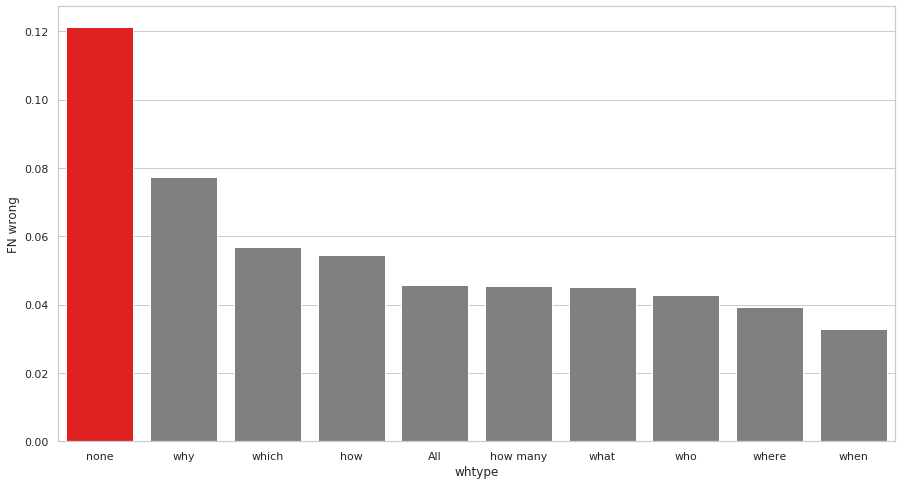

In [48]:
cmap = sns.cubehelix_palette(8)
plt.figure(figsize=(15,8))
clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
sns.barplot(x=solvable_table_m_ratio.index, y="FN wrong", data=solvable_table_m_ratio, palette=clrs)
ax.set_title('[SQuAD 2.0] Difficulty per wh-type for MRQA models', fontsize=15)

In [33]:
tmp = solvable_table.div(solvable_table["RowTotal"], axis=0)
tmp = tmp.sort_values(['Right'], ascending=[1])

In [34]:
ll = []
for idx, row in tmp.iterrows():
    ll.append((row['Wrong Answer'], row['FN wrong'],row['FP wrong'],row['Right']))

In [45]:
tmp.index

Index(['implicit_what', 'none', 'name', 'how', 'why', 'where', 'All', 'what',
       'which', 'how many', 'who', 'when'],
      dtype='object', name='whtype')

In [46]:
ll

[(0.5, 0.5, 0.0, 0.0),
 (0.14432989690721648,
  0.1134020618556701,
  0.20618556701030927,
  0.5360824742268041),
 (0.36363636363636365, 0.0, 0.0, 0.6363636363636364),
 (0.1721311475409836,
  0.0546448087431694,
  0.10655737704918032,
  0.6666666666666666),
 (0.15979381443298968,
  0.07731958762886598,
  0.06701030927835051,
  0.6958762886597938),
 (0.1016597510373444,
  0.03941908713692946,
  0.0995850622406639,
  0.7593360995850622),
 (0.07074875768550493,
  0.04581824307251748,
  0.07883432999241978,
  0.8045986692495578),
 (0.07146702557200538,
  0.04508748317631225,
  0.07792732166890982,
  0.8055181695827726),
 (0.08023483365949119,
  0.05675146771037182,
  0.0547945205479452,
  0.8082191780821918),
 (0.044296788482835,
  0.04540420819490587,
  0.07751937984496124,
  0.832779623477298),
 (0.040214477211796246,
  0.04289544235924933,
  0.07596067917783736,
  0.840929401251117),
 (0.027704485488126648,
  0.032981530343007916,
  0.0712401055408971,
  0.8680738786279684)]

Text(0.5, 1.0, '[SQuAD 2.0] Difficulty per wh-type for MRQA models')

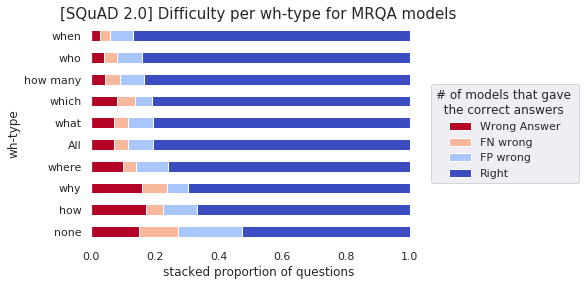

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib
sns.set()

df = pd.DataFrame(ll, columns=['Wrong Answer','FN wrong','FP wrong','Right'], 
                  index=tmp.index)
#df['unsolvable'] = -df['unsolvable']
ax = df.plot(title = '[SQuAD 2.0] Difficulty per wh-type for MRQA models', kind='barh', stacked=True, colormap='coolwarm_r')
ax.set_facecolor("w")
matplotlib.pyplot.ylabel('wh-type')
matplotlib.pyplot.xlabel('stacked proportion of questions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="# of models that gave \n  the correct answers")
ax.set_title('[SQuAD 2.0] Difficulty per wh-type for MRQA models', fontsize=15)

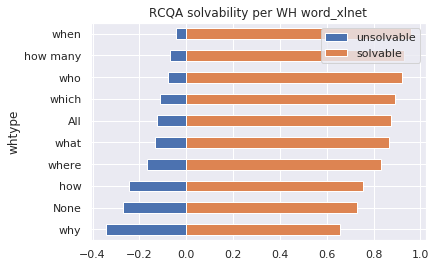

In [40]:
##  only xlnet
import pandas as pd
import seaborn as sns
sns.set()
df = pd.DataFrame(ll, columns=['unsolvable', 'solvable'], 
                  index=tmp.index)
df['unsolvable'] = -df['unsolvable']
df.plot(title = 'RCQA solvability per WH word_xlnet', kind='barh', stacked=True);

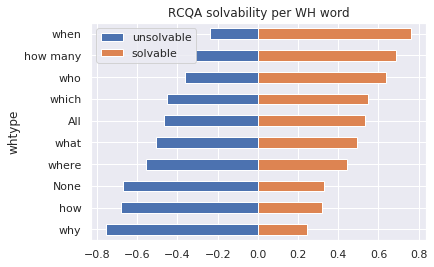

In [43]:
import pandas as pd
import seaborn as sns
sns.set()

df = pd.DataFrame(ll, columns=['unsolvable', 'solvable'], 
                  index=tmp.index)
df['unsolvable'] = -df['unsolvable']
df.plot(title = 'RCQA solvability per WH word', kind='barh', stacked=True);

## LAT type wrong probability

In [77]:
def PosTagger(sentence):    
    '''
    POS Tagger
    
    @return the tuple of token and POS tag in sentence
    '''
    doc = nlp(sentence)
    poslist = []

    for token in doc:
        poslist.append((token.text, token.tag_))
    
    return poslist

In [78]:
def detailAnsType(question):
    '''
    Find detail answer type
    
    @return the detail answer type
    '''
    st = False
    ans = ''
    PTs = PosTagger(question)
    
    #print (PTs)
    
    for idx, w in enumerate(PTs):
        if w[0].lower() == 'what' or w[0].lower() == 'which':
            st = True
            continue
        #print(w)
        if st == True and (w[0].lower() == 'did' or w[0].lower() == 'does'): break
        if st == True and (w[1] == 'NN' or w[1] == 'NNP' or w[1] == 'NNS'):
            if 'kind' in w[0].lower() or 'name' in w[0].lower() or 'type' in w[0].lower() or (idx < len(PTs)-1 and "\'s" in PTs[idx+1][0].lower()):
                continue
                
            for j in range(idx, len(PTs)):
                if PTs[j][0][0].isupper():
                    ans = ''
                    break
                if not (PTs[j][1] == 'NN' or PTs[j][1] == 'NNP' or PTs[j][1] == 'NNS'):
                    if "\'s" in PTs[j][0].lower():
                        ans = ''
                        break
                    else: return (ans, PTs[j-1][0])
                ans += PTs[j][0]+' '
                
    
    return ("None","None")

In [79]:
lat_group = Counter()
lat_list = []

for document in tqdm_notebook(data):
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            question = clearquestion(qas['question'])
            
            lat_d, lat_s = detailAnsType(question)
            lat_list.append(lat_s)
    
            lat_group[lat_s] += 1

In [172]:
qid_dict2 = {'qid': qid_list, 'whtype': whtype_list, 'lattype': lat_list, 'bert_solvable': bert_solvable, 'wrong_type': wrong_type_list}

In [174]:
df2 = pd.DataFrame(qid_dict2)

In [175]:
df2

,qid,whtype,lattype,bert_solvable,wrong_type
0,56ddde6b9a695914005b9628,what,country,True,-
1,56ddde6b9a695914005b9629,when,None,True,-
2,56ddde6b9a695914005b962a,which,countries,True,-
3,56ddde6b9a695914005b962b,who,None,True,-
4,56ddde6b9a695914005b962c,what,century,True,-
...,...,...,...,...,...
11868,5737aafd1c456719005744ff,what,unit,False,fn
11869,5ad28ad0d7d075001a4299cc,what,None,True,-
11870,5ad28ad0d7d075001a4299cd,what,force,True,-
11871,5ad28ad0d7d075001a4299ce,what,force,True,-


In [83]:
df_filter = df2.loc[(df2['whtype'] == 'what') | (df2['whtype'] == 'which')]

In [84]:
df_filter

,qid,whtype,lattype,bert_solvable,wrong_type
0,56ddde6b9a695914005b9628,what,country,True,-
2,56ddde6b9a695914005b962a,which,countries,True,-
4,56ddde6b9a695914005b962c,what,century,True,-
6,5ad39d53604f3c001a3fe8d2,what,region,True,-
11,56dddf4066d3e219004dad61,what,religion,False,wa
...,...,...,...,...,...
11868,5737aafd1c456719005744ff,what,unit,False,fn
11869,5ad28ad0d7d075001a4299cc,what,None,True,-
11870,5ad28ad0d7d075001a4299cd,what,force,True,-
11871,5ad28ad0d7d075001a4299ce,what,force,True,-


In [85]:
df_filter = df_filter.drop(columns=['whtype','bert_solvable'])

In [86]:
latgroups = df_filter.groupby(['lattype']).count()

In [87]:
lat_freq = dict()
for lat in latgroups.iterrows():
    
    lat_freq[lat[0]] = lat[1].qid

In [93]:
df_filter

,qid,lattype,wrong_type
0,56ddde6b9a695914005b9628,country,-
2,56ddde6b9a695914005b962a,countries,-
4,56ddde6b9a695914005b962c,century,-
6,5ad39d53604f3c001a3fe8d2,region,-
11,56dddf4066d3e219004dad61,religion,wa
...,...,...,...
11868,5737aafd1c456719005744ff,unit,fn
11869,5ad28ad0d7d075001a4299cc,None,-
11870,5ad28ad0d7d075001a4299cd,force,-
11871,5ad28ad0d7d075001a4299ce,force,-


In [151]:
counts = df_filter.groupby(['lattype','wrong_type']).count()

In [152]:
counts

qid
lattype     wrong_type      
%           -              5
            wa             1
-           -              1
None        -           1144
            fn            72
...                      ...
year        fp            19
years       -             23
            fp             2
zooplankton -              1
°           -              2

[2417 rows x 1 columns]

In [153]:
counts = counts.unstack(level=1)
counts.columns = counts.columns.droplevel(level=0)
print (counts)

wrong_type        -    fn     fp     wa
lattype                                
%               5.0   NaN    NaN    1.0
-               1.0   NaN    NaN    NaN
None         1144.0  72.0  108.0  119.0
aan             1.0   NaN    NaN    NaN
ability         1.0   NaN    NaN    1.0
...             ...   ...    ...    ...
xenoliths       1.0   NaN    NaN    NaN
year          281.0   7.0   19.0    NaN
years          23.0   NaN    2.0    NaN
zooplankton     1.0   NaN    NaN    NaN
°               2.0   NaN    NaN    NaN

[1701 rows x 4 columns]


In [154]:
counts = counts.fillna(0)
counts['Total'] = counts.sum(axis=1)

In [155]:
#counts1 = counts1.sort_values(['Total'], ascending=[0])
#counts2 = counts2.sort_values(['Total'], ascending=[0])
counts = counts.sort_values(['Total'], ascending=[0])
#counts_xlnet = counts_xlnet.sort_values(['Total'], ascending=[0])

In [156]:
counts_count = counts

In [ ]:
## [todo] weighted sum bw 0~4 models

In [92]:
count_check = list(counts_count.Total)

c = list(filter(lambda x: x >= 20, count_check))

In [93]:
len(c)

39

In [157]:
result_sample_count = counts_count.head(100)

In [158]:
result_sample_count.keys()

Index(['-', 'fn', 'fp', 'wa', 'Total'], dtype='object', name='wrong_type')

In [159]:
result_sample_count.columns = ['Right','FN wrong','FP wrong','Wrong Answer',"Total"]

In [160]:
result_sample_count

,Right,FN wrong,FP wrong,Wrong Answer,Total
lattype,,,,,
None,1144.0,72.0,108.0,119.0,1443.0
year,281.0,7.0,19.0,0.0,307.0
percentage,66.0,3.0,12.0,2.0,83.0
country,59.0,8.0,7.0,8.0,82.0
term,67.0,4.0,5.0,3.0,79.0
...,...,...,...,...,...
sector,9.0,2.0,0.0,0.0,11.0
date,10.0,0.0,1.0,0.0,11.0
county,9.0,2.0,0.0,0.0,11.0


In [161]:

columns = ['Right', 'FN wrong', 'FP wrong','Wrong Answer']
for i in range(4):
    result_sample_count[columns[i]] = result_sample_count[columns[i]]/result_sample_count['Total']

/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
result_sample_count

,Right,FN wrong,FP wrong,Wrong Answer,Total
lattype,,,,,
None,0.792793,0.049896,0.074844,0.082467,1443.0
year,0.915309,0.022801,0.061889,0.000000,307.0
percentage,0.795181,0.036145,0.144578,0.024096,83.0
country,0.719512,0.097561,0.085366,0.097561,82.0
term,0.848101,0.050633,0.063291,0.037975,79.0
...,...,...,...,...,...
sector,0.818182,0.181818,0.000000,0.000000,11.0
date,0.909091,0.000000,0.090909,0.000000,11.0
county,0.818182,0.181818,0.000000,0.000000,11.0


In [162]:
## 1, 0.5, 0.25

import numpy as np

urgent_list = []
wrong_score_list = []
freq_list = []
freq_log_list = []
for lat, instance in result_sample_count.iterrows():    
    wrong_score = instance[1]+instance[2]+instance[3]
    freq_log = np.log(instance['Total'])
    freq = instance['Total']
    
    wrong_score_list.append(wrong_score)
    freq_list.append(int(freq))
    freq_log_list.append(freq_log)
    
    urgent = wrong_score*freq
    urgent_list.append(urgent)

In [163]:
result_sample_count['freq'] = freq_list
result_sample_count['freq_log'] = freq_log_list
result_sample_count['wrong_score'] = wrong_score_list
result_sample_count['urgent'] = urgent_list

/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [142]:
result_sample_count = result_sample_count.sort_values(['urgent'], ascending=[0])

In [125]:
tmp = result_sample_count.copy(deep = True)

In [126]:
roundtmp = tmp.round(decimals=3)

In [129]:
roundtmp[:10]

,Right,FN wrong,FP wrong,Wrong Answer,Total,freq,freq_log,wrong_score,urgent
lattype,,,,,,,,,
None,0.793,0.050,0.075,0.082,1443.0,1443,7.274,0.207,299.0
year,0.915,0.023,0.062,0.000,307.0,307,5.727,0.085,26.0
country,0.720,0.098,0.085,0.098,82.0,82,4.407,0.280,23.0
percentage,0.795,0.036,0.145,0.024,83.0,83,4.419,0.205,17.0
impact,0.400,0.100,0.200,0.300,20.0,20,2.996,0.600,12.0
term,0.848,0.051,0.063,0.038,79.0,79,4.369,0.152,12.0
example,0.793,0.052,0.052,0.103,58.0,58,4.060,0.207,12.0
city,0.859,0.038,0.077,0.026,78.0,78,4.357,0.141,11.0
reason,0.607,0.071,0.143,0.179,28.0,28,3.332,0.393,11.0


In [125]:
result_sample_alo['ratio'] = result_sample_alo[False]/result_sample_alo['Total']
result_sample_all['ratio'] = result_sample_all[False]/result_sample_all['Total']

/home/doyeon/anaconda3/envs/kcc/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/doyeon/anaconda3/envs/kcc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
result_sample_xlnet['ratio'] = result_sample_xlnet[False]/result_sample_xlnet['Total']

/home/doyeon/anaconda3/envs/kcc/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [126]:
result_sample_alo = result_sample_alo.sort_values(['ratio'], ascending=[0])
result_sample_all = result_sample_all.sort_values(['ratio'], ascending=[0])

In [127]:
result_sample_alo.columns = ['False','True','Total','Ratio']
result_sample_all.columns = ['False','True','Total','Ratio']

In [58]:
result_sample_xlnet = result_sample_xlnet.sort_values(['ratio'], ascending=[0])
result_sample_xlnet.columns = ['False','True','Total','Ratio']

In [103]:
result_sample_count.columns = ['0','1','2','3','4','Total','freq','freq_log','wrong_score','urgent']

In [164]:
result_sample_count['score'] = result_sample_count['Right']

/home/doyeon/anaconda3/envs/qa_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [165]:
result_sample_count = result_sample_count.sort_values(['score'], ascending=[1])

In [166]:
result_sample_count

,Right,FN wrong,FP wrong,Wrong Answer,Total,freq,freq_log,wrong_score,urgent,score
lattype,,,,,,,,,,
impact,0.400000,0.100000,0.200000,0.300000,20.0,20,2.995732,0.600000,12.0,0.400000
level,0.533333,0.066667,0.333333,0.066667,15.0,15,2.708050,0.466667,7.0,0.533333
goal,0.565217,0.217391,0.086957,0.130435,23.0,23,3.135494,0.434783,10.0,0.565217
disobedience,0.583333,0.333333,0.000000,0.083333,12.0,12,2.484907,0.416667,5.0,0.583333
reason,0.607143,0.071429,0.142857,0.178571,28.0,28,3.332205,0.392857,11.0,0.607143
...,...,...,...,...,...,...,...,...,...,...
case,1.000000,0.000000,0.000000,0.000000,21.0,21,3.044522,0.000000,0.0,1.000000
machine,1.000000,0.000000,0.000000,0.000000,11.0,11,2.397895,0.000000,0.0,1.000000
building,1.000000,0.000000,0.000000,0.000000,18.0,18,2.890372,0.000000,0.0,1.000000


In [109]:
result_sample_xlnet['False'] /= result_sample_xlnet['Total']
result_sample_xlnet['True'] /= result_sample_xlnet['Total']

NameError: name 'result_sample_xlnet' is not defined

In [128]:
result_sample_alo['False'] /= result_sample_alo['Total']
result_sample_alo['True'] /= result_sample_alo['Total']

result_sample_all['False'] /= result_sample_all['Total']
result_sample_all['True'] /= result_sample_all['Total']

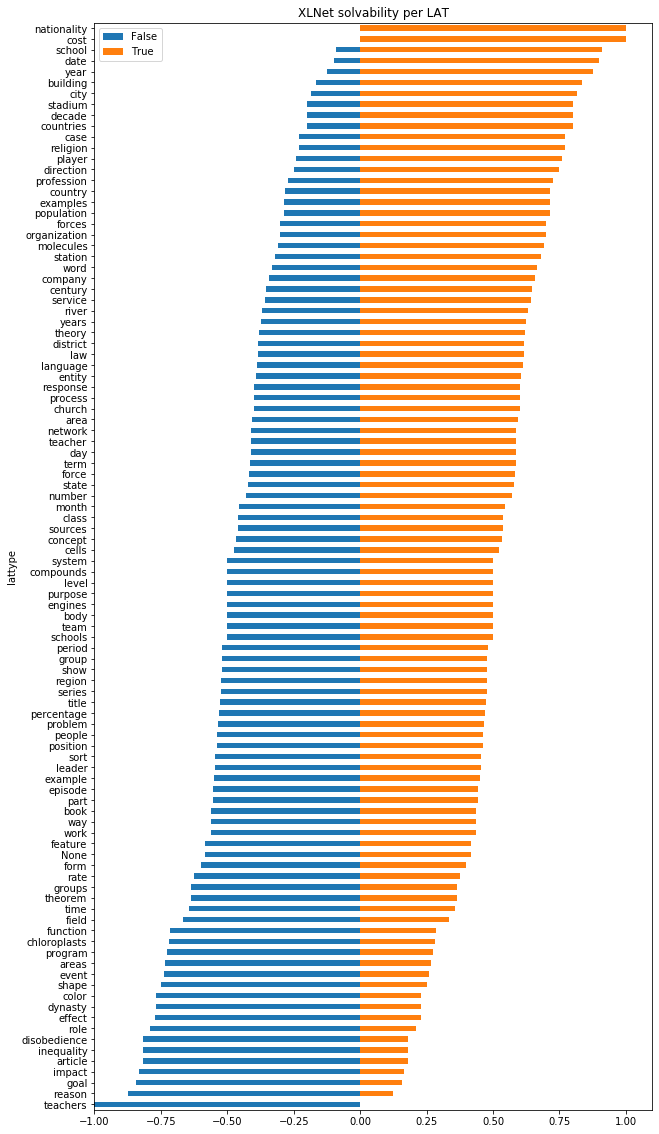

In [129]:
result_sample_alo = result_sample_alo[['False','True']]
result_sample_alo['False'] = -result_sample_alo['False']
result_sample_alo.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'XLNet solvability per LAT')

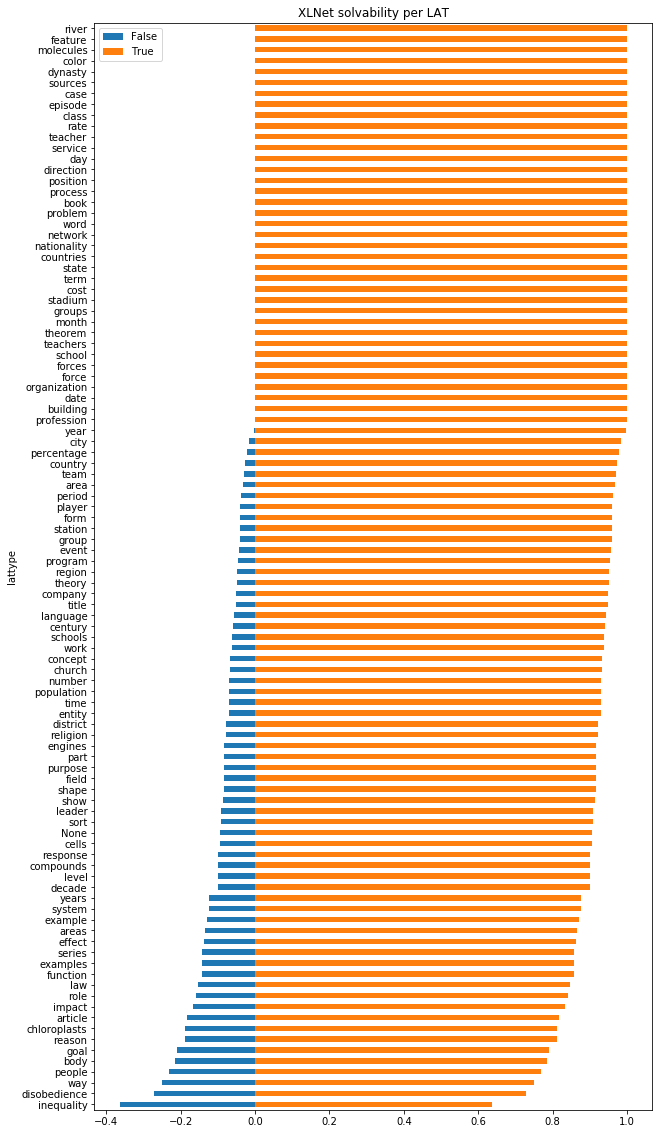

In [130]:
result_sample_all = result_sample_all[['False','True']]
result_sample_all['False'] = -result_sample_all['False']
result_sample_all.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'XLNet solvability per LAT')

/home/doyeon/anaconda3/envs/kcc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


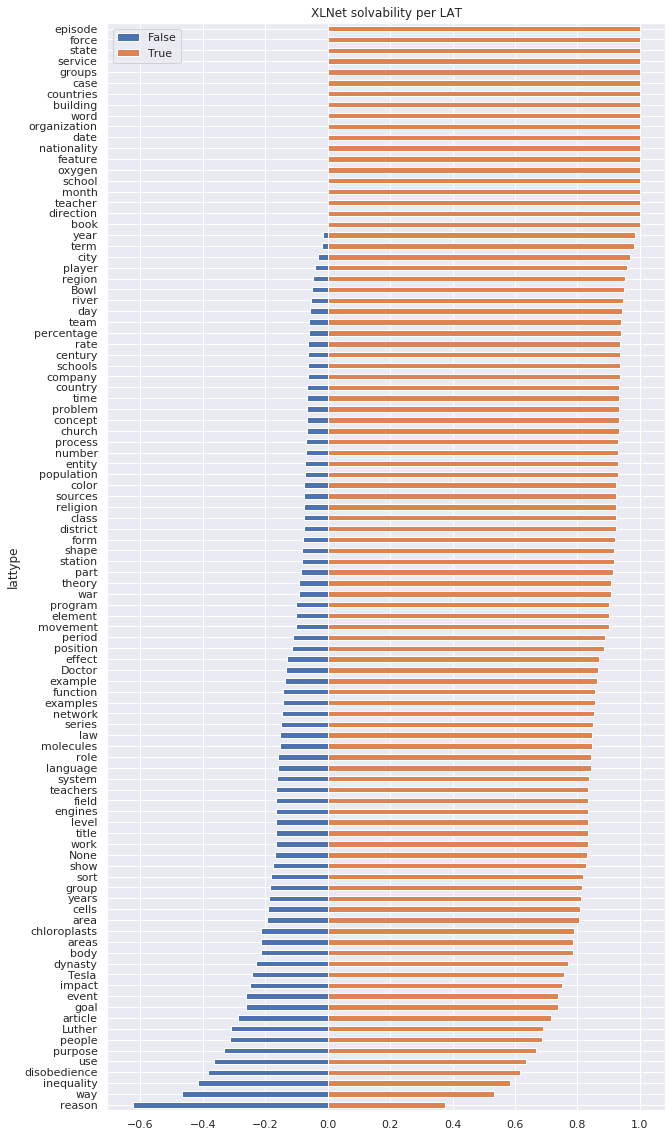

In [62]:
result_sample_xlnet = result_sample_xlnet[['False','True']]
result_sample_xlnet['False'] = -result_sample_xlnet['False']
result_sample_xlnet.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'XLNet solvability per LAT')

Text(0.5, 1.0, 'Difficulty per LAT type for MRQA models')

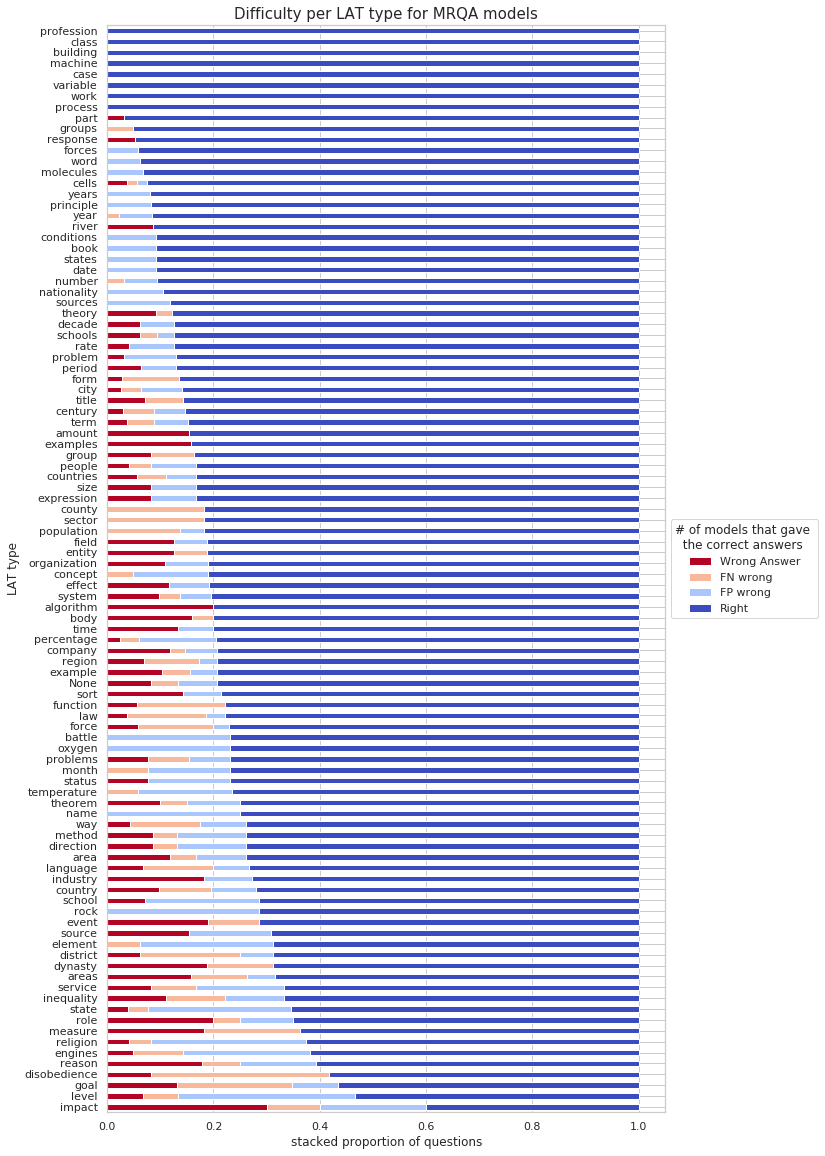

In [167]:
import matplotlib

result_sample_count = result_sample_count[['Wrong Answer','FN wrong','FP wrong','Right']]
#result_sample_alo['False'] = -result_sample_alo['False']
ax = result_sample_count.plot(figsize=(10,20), kind='barh', stacked=True , colormap='coolwarm_r')

ax.set_facecolor("w")
matplotlib.pyplot.ylabel('LAT type')
matplotlib.pyplot.xlabel('stacked proportion of questions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="# of models that gave \n  the correct answers")
ax.set_title('Difficulty per LAT type for MRQA models', fontsize=15)

In [180]:
with open("./squad/train-v2.0.json", "r") as f:
    train = json.load(f)

In [184]:
def get_at(question):
    wh_word = findWHword(question)
    if wh_word == 'None':
        return 'None'
    elif wh_word == 'what' or wh_word == 'which':
        return detailAnsType(question)[1] #we don't need the detailed ans type
    else:
        return wh_word
assert get_at('Where was Obama born?') == "where"
assert get_at('When was Obama born?') == "when"
assert get_at('In which country was Obama born?') == 'country'
assert get_at('What policy did he follow?') == 'policy'
assert get_at('What to do in Seoul') == 'None'

def increment_frequency(d, k):
    if k in d:
        d[k] = d[k]+1
    else:
        d[k] = 1

dict_freq_lat = {}

for document in tqdm_notebook(train['data']):
    for paragraph in document['paragraphs']:
        for qas in paragraph['qas']:
            question = clearquestion(qas['question'])
            at = get_at(question)
            increment_frequency(dict_freq_lat, at)

In [185]:
df = df2

In [186]:
df

df_filter = df.loc[(df['whtype'] == 'what') | (df['whtype'] == 'which')]

df_bert = df_filter[['qid','lattype','bert_solvable']]

count_bert = df_bert.groupby(['lattype','bert_solvable']).count()


count_bert = count_bert.unstack(level=1)
count_bert.columns = count_bert.columns.droplevel(level=0)
print (count_bert)


count_bert = count_bert.fillna(0)
count_bert['Total'] = count_bert.sum(axis=1)

result_bert = count_bert

result_bert['ratio'] = result_bert[True]/result_bert['Total']

average_correct_rate = dict()
dot = []
for lat in result_bert.index:
    summa = result_bert.loc[lat, 'ratio']
    avg = summa
    
    if lat in dict_freq_lat:
        dot.append((dict_freq_lat[lat], avg))

bert_solvable  False   True 
lattype                     
%                1.0     5.0
-                NaN     1.0
None           299.0  1144.0
aan              NaN     1.0
ability          1.0     1.0
...              ...     ...
xenoliths        NaN     1.0
year            26.0   281.0
years            2.0    23.0
zooplankton      NaN     1.0
°                NaN     2.0

[1701 rows x 2 columns]


Text(0.5, 1.0, 'Correlation between the Number of Dataset and Accuracy in LAT Anaylsis_SQuAD2')

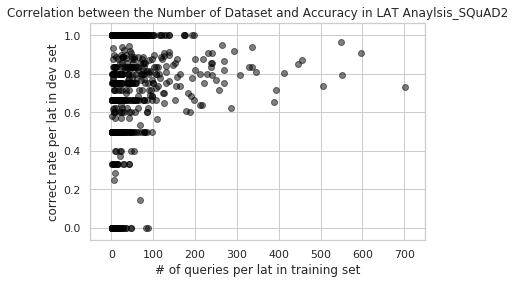

In [188]:
import matplotlib

fig = plt.figure(1)
ax = fig.add_subplot(111, facecolor='white')

x,y = zip(*dot)
plt.scatter(x, y, color='black', alpha= 0.5)
plt.xlim(-50, 750)
np.corrcoef(x, y)
#ax.set_facecolor("w")
matplotlib.pyplot.ylabel('correct rate per lat in dev set')
matplotlib.pyplot.xlabel('# of queries per lat in training set')
plt.title('Correlation between the Number of Dataset and Accuracy in LAT Anaylsis_SQuAD2')

In [194]:
result_sample_alo = result_sample_alo[['False','True']]
result_sample_alo['False'] = -result_sample_alo['False']
result_sample_alo.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'RC solvability per LAT')

KeyError: "None of [Index(['False', 'True'], dtype='object', name='RC_solvable')] are in the [columns]"

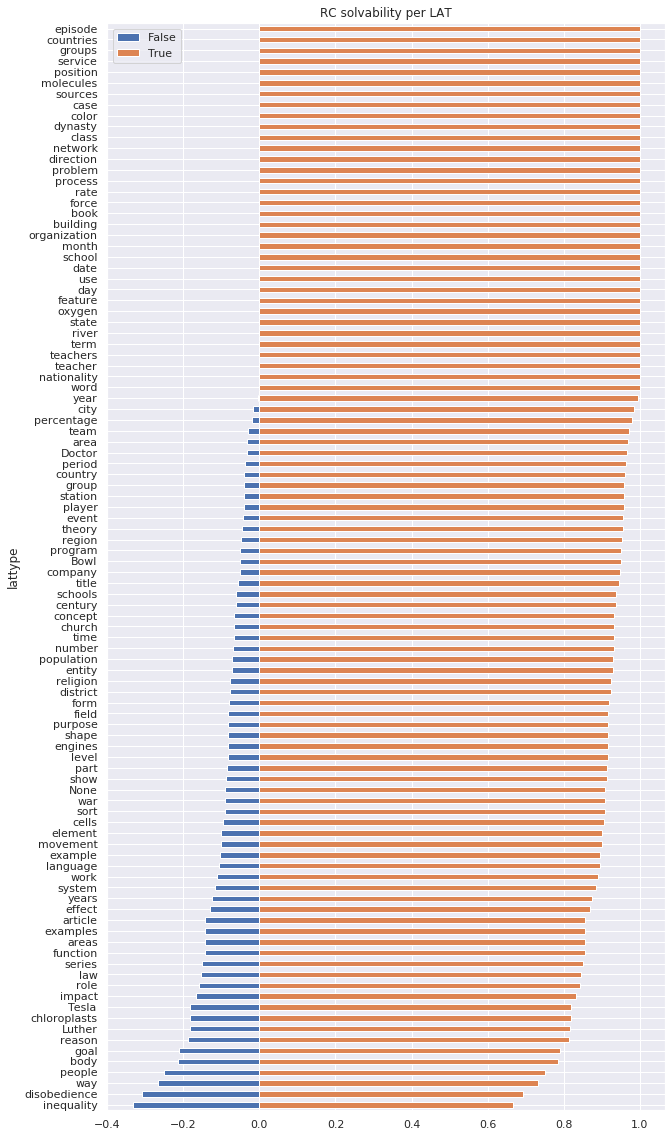

In [127]:
result_sample_all = result_sample_all[['False','True']]
result_sample_all['False'] = -result_sample_all['False']
result_sample_all.plot(figsize=(10,20), kind='barh', stacked=True ,title = 'RC solvability per LAT')

In [173]:
pd.DataFrame(rand(10, 4))

,0,1,2,3
0,0.070429,0.314044,0.198377,0.046965
1,0.749975,0.313324,0.588196,0.009443
2,0.048844,0.023699,0.762604,0.092510
3,0.564028,0.023477,0.137801,0.141642
4,0.378162,0.212360,0.256653,0.705599
5,0.041651,0.066077,0.120181,0.473346
6,0.256582,0.133719,0.114964,0.538792
7,0.220245,0.159481,0.318749,0.242615
8,0.503184,0.947943,0.611468,0.419353
9,0.440137,0.689202,0.118517,0.299765


In [237]:
PosTagger("a,b,c,d or e is alphabet")

[('a', 'DT'),
 (',', ','),
 ('b', 'NN'),
 (',', ','),
 ('c', 'NN'),
 (',', ','),
 ('d', 'NN'),
 ('or', 'CC'),
 ('e', 'NN'),
 ('is', 'VBZ'),
 ('alphabet', 'JJ')]

## NN list check

In [239]:
entity_list_qid = []
for instance in tqdm_notebook(dev):
    
    question = clearquestion(instance['Question'])
    pos_list = PosTagger(question)
    
    posstr = ""
    for word, pos in pos_list:
        posstr += pos
    
    if ('NNCCNN' in posstr) or ('NN,NN' in posstr): 
        entity_list_qid.append(instance['QuestionId'])

In [244]:
len(set(entity_list_qid) & rc_wrong) / len(set(entity_list_qid))

0.5345345345345346

In [358]:
 len(set(entity_list_qid))

333

## qualitative analysis

### four failure case

In [88]:
aaa = "'5728e8212ca10214002daa6f	56e1bc3ae3433e1400423107	5726e179dd62a815002e93b0	573060b48ab72b1400f9c4c7	5725c0f289a1e219009abdf2	570d4e6cb3d812140066d671	572fc8a904bcaa1900d76d21	57060a6e52bb8914006897fa	572864542ca10214002da2e2	57263ea0271a42140099d7c4	571ce9bddd7acb1400e4c1a1'"

In [89]:
ns = "','".join(aaa.split("\t"))
ns

"'5728e8212ca10214002daa6f','56e1bc3ae3433e1400423107','5726e179dd62a815002e93b0','573060b48ab72b1400f9c4c7','5725c0f289a1e219009abdf2','570d4e6cb3d812140066d671','572fc8a904bcaa1900d76d21','57060a6e52bb8914006897fa','572864542ca10214002da2e2','57263ea0271a42140099d7c4','571ce9bddd7acb1400e4c1a1'"

In [2]:
at_lat_clear = ['5726534d708984140094c26e','570d4030fed7b91900d45da3','56e1e9dfe3433e14004231fe','57302bd0b2c2fd14005689dc','57264e455951b619008f6f65','571098f8a58dae1900cd6ab2','57060a6e52bb8914006897fa']
at_lat_abstract = ['56e1bc3ae3433e1400423107','5728e8212ca10214002daa6f','5726e179dd62a815002e93b0','573060b48ab72b1400f9c4c7','571ce9bddd7acb1400e4c1a1']
at_wh_clear = ['572fc8a904bcaa1900d76d21','57286dfa2ca10214002da332']
at_wh_abstract = ['572691545951b619008f76e3','570d4e6cb3d812140066d671','572864542ca10214002da2e2']
nonat = ['5725c0f289a1e219009abdf2','5727ff083acd2414000df1ae','57263ea0271a42140099d7c4']

short = ['56e1bc3ae3433e1400423107','570d4030fed7b91900d45da3','56e1e9dfe3433e14004231fe','5726e179dd62a815002e93b0','573060b48ab72b1400f9c4c7','57302bd0b2c2fd14005689dc','57264e455951b619008f6f65','571098f8a58dae1900cd6ab2','572fc8a904bcaa1900d76d21','57060a6e52bb8914006897fa','5727ff083acd2414000df1ae']
explain = ['5726534d708984140094c26e','5728e8212ca10214002daa6f','572691545951b619008f76e3','5725c0f289a1e219009abdf2','570d4e6cb3d812140066d671','572864542ca10214002da2e2','57263ea0271a42140099d7c4','571ce9bddd7acb1400e4c1a1']

alias = ['5728e8212ca10214002daa6f','570d4030fed7b91900d45da3','57264e455951b619008f6f65','572691545951b619008f76e3','5725c0f289a1e219009abdf2','571098f8a58dae1900cd6ab2','572fc8a904bcaa1900d76d21','572864542ca10214002da2e2']
boundary = ['5726534d708984140094c26e','5728e8212ca10214002daa6f','56e1bc3ae3433e1400423107','56e1e9dfe3433e14004231fe','573060b48ab72b1400f9c4c7','57302bd0b2c2fd14005689dc','5725c0f289a1e219009abdf2','570d4e6cb3d812140066d671','572fc8a904bcaa1900d76d21','5727ff083acd2414000df1ae','57263ea0271a42140099d7c4','571ce9bddd7acb1400e4c1a1']
wrong_context = ['5728e8212ca10214002daa6f','56e1bc3ae3433e1400423107','5726e179dd62a815002e93b0','573060b48ab72b1400f9c4c7','5725c0f289a1e219009abdf2','570d4e6cb3d812140066d671','572fc8a904bcaa1900d76d21','57060a6e52bb8914006897fa','572864542ca10214002da2e2','57263ea0271a42140099d7c4','571ce9bddd7acb1400e4c1a1']
at_wrong = []
modifier = ['57286dfa2ca10214002da332']


In [3]:
at_lat_clear = set(at_lat_clear)
at_lat_abstract = set(at_lat_abstract)
at_wh_clear = set(at_wh_clear)
at_wh_abstract = set(at_wh_abstract)
nonat = set(nonat)

short = set(short)
explain = set(explain)

alias = set(alias)
boundary = set(boundary)
wrong_context = set(wrong_context)
at_wrong = set(at_wrong)
modifier = set(modifier)

In [4]:
at_lat_clear & short

{'56e1e9dfe3433e14004231fe',
 '57060a6e52bb8914006897fa',
 '570d4030fed7b91900d45da3',
 '571098f8a58dae1900cd6ab2',
 '57264e455951b619008f6f65',
 '57302bd0b2c2fd14005689dc'}

In [5]:
at_lat_clear & explain

{'5726534d708984140094c26e'}

In [11]:
## query type
print ("lat clear: {}, lat abstract: {}, wh clear: {}, wh abstract: {}, Non AT: {} ".format(len(at_lat_clear), len(at_lat_abstract), len(at_wh_clear), len(at_wh_abstract), len(nonat)))

lat clear: 7, lat abstract: 5, wh clear: 2, wh abstract: 3, Non AT: 3 


In [6]:
## LAT clear
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(at_lat_clear&alias), len(at_lat_clear&alias), len(at_lat_clear&boundary), len(at_lat_clear&at_wrong), len(at_lat_clear&modifier)))

alias: 3, boundary: 3, wrong context: 3, AT wrong: 0, modifier: 0 


In [7]:
## LAT abstract
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(at_lat_abstract&alias), len(at_lat_abstract&alias), len(at_lat_abstract&boundary), len(at_lat_abstract&at_wrong), len(at_lat_abstract&modifier)))

alias: 1, boundary: 1, wrong context: 4, AT wrong: 0, modifier: 0 


In [8]:
## WH clear
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(at_wh_clear&alias), len(at_wh_clear&alias), len(at_wh_clear&boundary), len(at_wh_clear&at_wrong), len(at_wh_clear&modifier)))

alias: 1, boundary: 1, wrong context: 1, AT wrong: 0, modifier: 1 


In [9]:
## WH abstract
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(at_wh_abstract&alias), len(at_wh_abstract&alias), len(at_wh_abstract&boundary), len(at_wh_abstract&at_wrong), len(at_wh_abstract&modifier)))

alias: 2, boundary: 2, wrong context: 1, AT wrong: 0, modifier: 0 


In [10]:
## Non AT 
print ("alias: {}, boundary: {}, wrong context: {}, AT wrong: {}, modifier: {} ".format(len(nonat&alias), len(nonat&alias), len(nonat&boundary), len(nonat&at_wrong), len(nonat&modifier)))

alias: 1, boundary: 1, wrong context: 3, AT wrong: 0, modifier: 0 
